<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/documentation/assets/SG_img/SG%20-%20Horizontal%20Glow.png'>

# Quantization Aware Training YoloNAS on Custom Dataset



**Background**: Our research team developed a new deep learning architecture that competes with YOLOv8 using our efficient AutoNAC algorithm.
The new model, named YoloNAS, incorporates quantization-aware RepVGG blocks into the model architecture to ensure compatibility with Post-Training Quantization, making it more flexible and usable for different hardware configurations.


In this tutorial, we will demonstrate how to fine-tune the small variant of the YoloNAS, YoloNAS_S on a custom dataset from Hugging Face hub.

0. Installations and dataset setup.
1. Initialize train and validation dataloaders.
2. Define training hyper-parameters.
3. Instantiate a pre-trained YoloNAS_S model and launch training.
4. Run prediction on a real world input.
5. Load the best checkpoint from 3., perform post-training quantization and quantization-aware training.


Prerequisites:
- QAT/PTQ tutorials: [classification notebook](https://github.com/Deci-AI/super-gradients/blob/master/tutorials/PTQ_and_QAT_for_classification.ipynb), [Thorough tutorial](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ptq_qat.md)
- Training object detection models in SG: [Transfer learning notebook](https://bit.ly/3SkMohx).

It is also recommended to see the QAT/PTQ [tutorial](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj125-xvIv_AhVZhP0HHWQnCZYQFnoECBYQAQ&url=https%3A%2F%2Fwww.nvidia.com%2Fen-us%2Fon-demand%2Fsession%2Fgtcspring21-s31653%2F&usg=AOvVaw1i_93iFvK5HJDm_5-SXyMN) from NVidia.

# Installations

In [1]:
!pip install -qq super-gradients==3.8.0 datasets[vision]~=2.1 pandas~=2.0

# Dataset Setup

In [2]:
from datasets import load_dataset

dataset = load_dataset("cppe-5")

In [3]:
CLASS_NAMES = dataset["train"].features["objects"].feature["category"].names
NUM_CLASSES = len(CLASS_NAMES)

In [4]:
from tqdm import tqdm
import cv2
import json
import os
import numpy as np


def convert_hf_to_coco(dataset_split, output_images_directory, output_annotation_json):
    class_names = dataset["train"].features["objects"].feature["category"].names

    coco_annotation = {
        "images": [],
        "annotations": [],
        "categories": [{"supercategory": name, "name": name, "id": category_id} for category_id, name in enumerate(class_names)],
    }

    os.makedirs(output_images_directory, exist_ok=True)

    annotation_id = 1

    for sample in tqdm(dataset_split):
        image_id = sample["image_id"]
        image = np.array(sample["image"])

        objects = sample["objects"]
        areas = objects["area"]
        bboxes = objects["bbox"]  # XYWH
        category_ids = objects["category"]

        for object_area, object_bbox, object_category in zip(areas, bboxes, category_ids):
            coco_annotation["annotations"].append(
                {
                    "id": annotation_id,
                    "category_id": object_category,
                    "area": float(object_area),
                    "iscrowd": 0,
                    "image_id": image_id,
                    "bbox": list(map(int, object_bbox)),
                }
            )
            annotation_id += 1

        filename = f"{image_id}.jpg"
        output_image_path = os.path.join(output_images_directory, filename)
        cv2.imwrite(output_image_path, image[..., ::-1])  # RGB to BGR

        coco_annotation["images"].append({"file_name": filename, "height": image.shape[0], "width": image.shape[1], "id": image_id})

    with open(output_annotation_json, "w") as f:
        json.dump(coco_annotation, f)


convert_hf_to_coco(dataset["train"], "cppe-5-coco/images/train", "cppe-5-coco/train_annotations.coco.json")
convert_hf_to_coco(dataset["test"], "cppe-5-coco/images/valid", "cppe-5-coco/valid_annotations.coco.json")

100%|██████████| 29/29 [00:00<00:00, 32.98it/s]


# Setup train and validation datasets

Next, we instantiate torch DataLoader objects, one for training and one for validation which will be used for training our model.


In [5]:
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.transforms.transforms import (
    DetectionRandomAffine,
    DetectionHSV,
    DetectionHorizontalFlip,
    DetectionPaddedRescale,
    DetectionStandardize,
    DetectionTargetsFormatTransform,
)
from super_gradients.training.utils.collate_fn import DetectionCollateFN

train_dataset_params = dict(
    data_dir="cppe-5-coco",
    images_dir="images/train",
    json_annotation_file="train_annotations.coco.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionRandomAffine(degrees=0.0, scales=(0.5, 1.5), shear=0.0, target_size=(640, 640), filter_box_candidates=False, border_value=128),
        DetectionHSV(prob=1.0, hgain=5, vgain=30, sgain=30),
        DetectionHorizontalFlip(prob=0.5),
        DetectionPaddedRescale(input_dim=(640, 640)),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(640, 640), output_format="LABEL_CXCYWH"),
    ],
)

valid_dataset_params = dict(
    data_dir="cppe-5-coco",
    images_dir="images/valid",
    json_annotation_file="valid_annotations.coco.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionPaddedRescale(input_dim=(640, 640), max_targets=300),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(640, 640), output_format="LABEL_CXCYWH"),
    ],
)

trainset = COCOFormatDetectionDataset(**train_dataset_params)
valset = COCOFormatDetectionDataset(**valid_dataset_params)

In [6]:
from torch.utils.data import DataLoader

NUM_WORKERS = 0
BATCH_SIZE = 16

train_dataloader_params = {
    "shuffle": True,
    "batch_size": BATCH_SIZE,
    "drop_last": True,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

val_dataloader_params = {
    "shuffle": False,
    "batch_size": BATCH_SIZE,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

train_loader = DataLoader(trainset, **train_dataloader_params)
valid_loader = DataLoader(valset, **val_dataloader_params)

# Defining training hyperparameters

In [7]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    "warmup_initial_lr": 1e-5,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.5,
    "optimizer": "AdamW",
    "zero_weight_decay_on_bias_and_bn": True,
    "lr_warmup_epochs": 1,
    "warmup_mode": "LinearEpochLRWarmup",
    "optimizer_params": {"weight_decay": 0.0001},
    "ema": False,
    "average_best_models": False,
    "ema_params": {"beta": 25, "decay_type": "exp"},
    "max_epochs": 1,
    "mixed_precision": True,
    "loss": PPYoloELoss(use_static_assigner=False, num_classes=NUM_CLASSES, reg_max=16),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=NUM_CLASSES,
            normalize_targets=True,
            include_classwise_ap=True,
            class_names=CLASS_NAMES,
            post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300, nms_threshold=0.7),
        )
    ],
    "metric_to_watch": "mAP@0.50",
}

# Instantiate YoloNAS model and launch training

We instantiate a YoloNAS_S model, pre-trained on the [COCO detection dataset](https://cocodataset.org/#home).
Notice we specify num_classes which is different from the 80 classes of COCO, which results in replacing the classification branch of our model's head.

In [8]:
from super_gradients.training import Trainer
from super_gradients.common.object_names import Models
from super_gradients.training import models

trainer = Trainer(experiment_name="yolo_nas_s_cppe-5", ckpt_root_dir="experiments")
model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, pretrained_weights="coco")
trainer.train(model=model, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader)

Validating: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]



# Step 4: Run prediction on a real world input.

Now, lets see our trained model in action. We load the best checkpoint from step 3, and simply call predict on a real-world image.

In [9]:
best_model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))
regular_metrics = trainer.test(model=best_model, test_loader=valid_loader)
regular_metrics

Testing:  50%|█████     | 1/2 [00:00<00:00,  1.11it/s]

{'PPYoloELoss/loss_cls': 1.5830314,
 'PPYoloELoss/loss_iou': 0.44443554,
 'PPYoloELoss/loss_dfl': 0.49973685,
 'PPYoloELoss/loss': 2.5272038,
 'Precision@0.50': 0.27012598514556885,
 'Recall@0.50': 0.39257869124412537,
 'mAP@0.50': 0.27331721782684326,
 'F1@0.50': 0.15891046822071075,
 'AP@0.50_Coverall': 0.8316991329193115,
 'AP@0.50_Face_Shield': 0.01989009790122509,
 'AP@0.50_Gloves': 0.28907617926597595,
 'AP@0.50_Goggles': 0.0,
 'AP@0.50_Mask': 0.2259206622838974,
 'Best_score_threshold': 0.17000000178813934,
 'Best_score_threshold_Coverall': 0.3799999952316284,
 'Best_score_threshold_Face_Shield': 0.09999999403953552,
 'Best_score_threshold_Gloves': 0.14000000059604645,
 'Best_score_threshold_Goggles': 0.0,
 'Best_score_threshold_Mask': 0.07999999821186066}

Testing: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


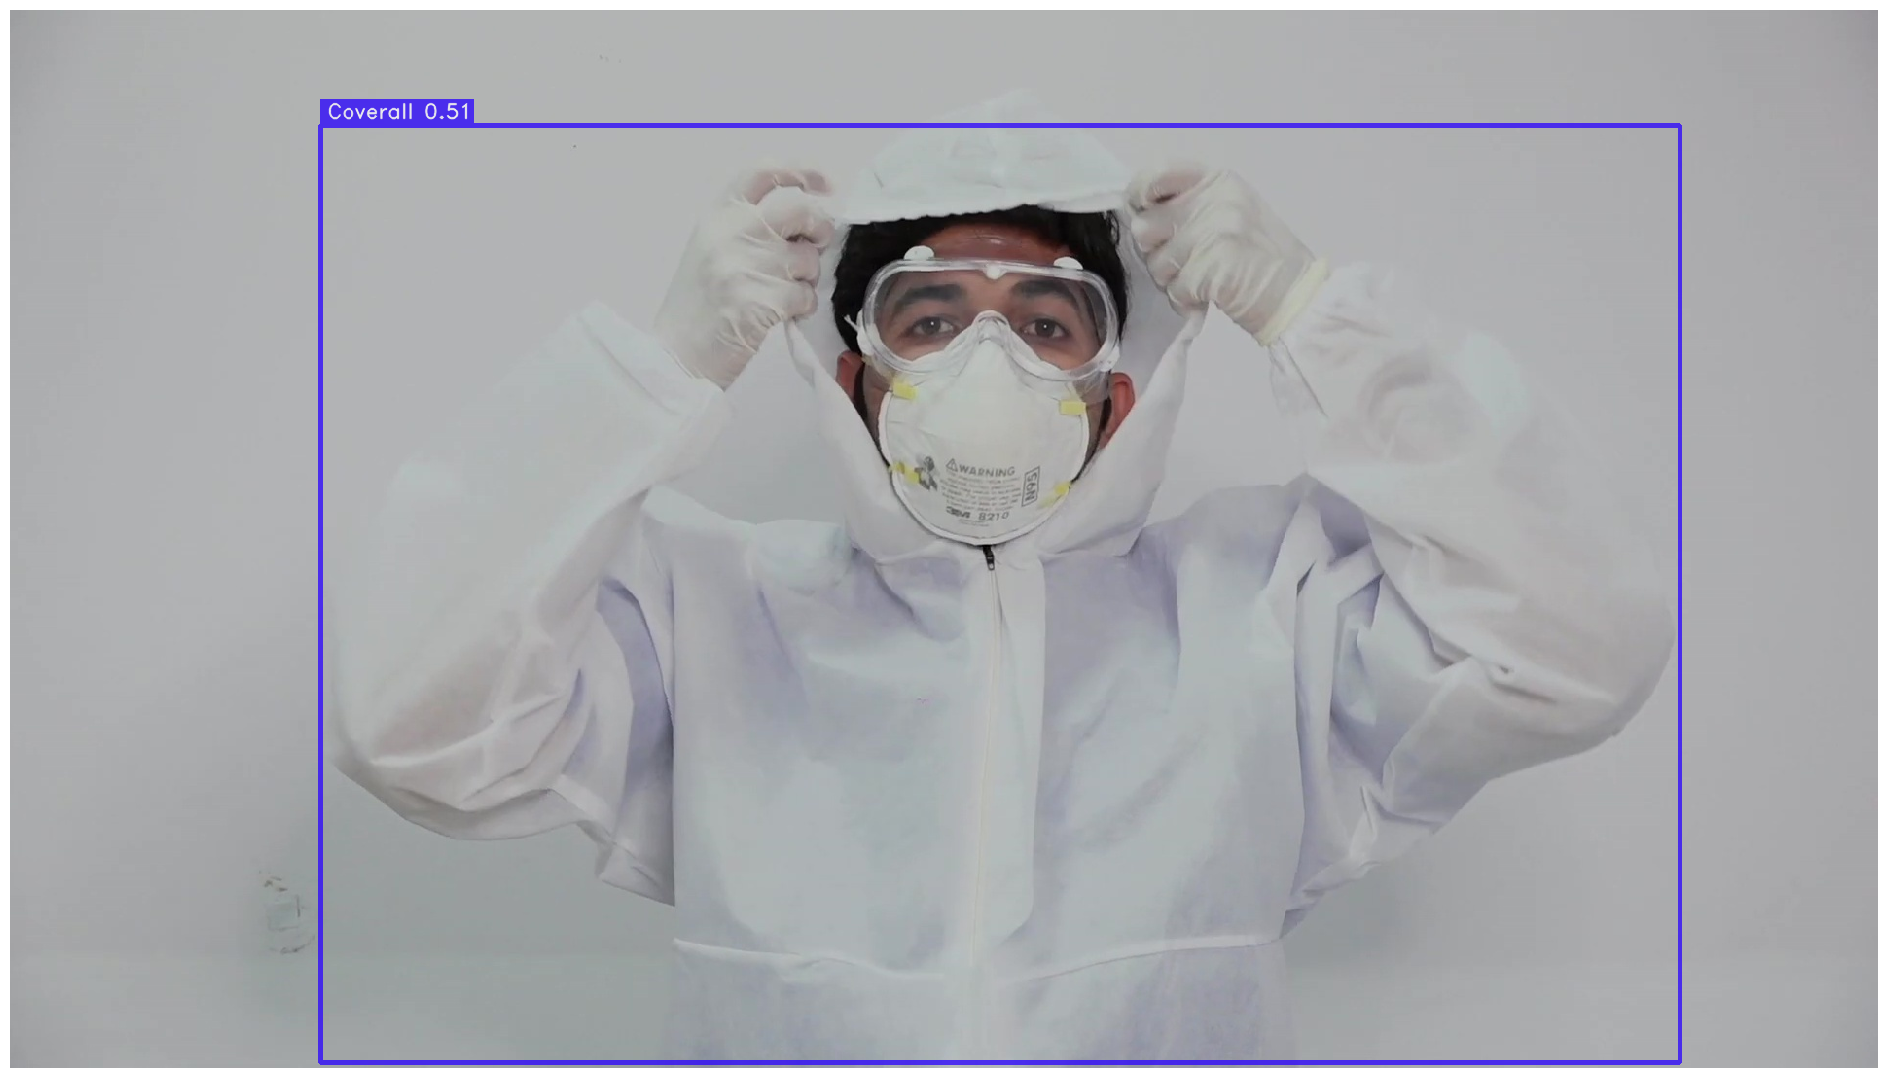

In [10]:
prediction = best_model.predict(dataset["test"][0]["image"], fuse_model=False)
prediction.show()

# Post-training quantization

We will now perform post-training quantization (PTQ) on our best model. 
This will result in a quantized model that can be used on hardware that supports INT8 operations.

A post-training quantization process is performed by the `ptq` method of the `Trainer` class. 
It converts the model's weights to INT8 and performs model calibration to minimize the accuracy loss. 
The calibration is done using a calibration data loader (`calib_loader`). 

To evalute the quantized model, we use the `valid_loader` parameter to specify the dataloader for validation. 
In this case, we use the same dataloader as we used during regular training to have apples-to-apples comparison.

Quantization is a last step before model deployment. So after PTQ we usually want to export the model to ONNX format, which is a common format for deployment.
The `export_params` parameter is used to specify the various arguments like batch size, whether pre- or post-processing should be applied, etc.
For example, if we set `preprocessing=True` and `postprocessing=True` so our detection model will take `uint8` RGB images and output detections after the NMS.

In [11]:
best_model_checkpoint_path = os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth")
best_model_checkpoint_path

'experiments\\yolo_nas_s_cppe-5\\RUN_20240416_145512_493465\\ckpt_best.pth'

In [12]:
from super_gradients.conversion import ExportParams

best_model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=best_model_checkpoint_path)

export_params = ExportParams(batch_size=1, preprocessing=True, postprocessing=True)

ptq_result = trainer.ptq(model=best_model, calib_loader=valid_loader, valid_loader=valid_loader, export_params=export_params)
ptq_metrics = ptq_result.valid_metrics_dict

NameError: name 'load_recipe' is not defined

### Inspect metrics of model after PTQ

In [ ]:
ptq_metrics

### Pretict with PTQ model

In [ ]:
prediction = ptq_result.quantized_model.predict(dataset["test"][0]["image"], fuse_model=False)
prediction.show()

# Quantization-aware training

Since all local variables are lost, we define again `train_params, train_dataset_params, val_dataset_params, train_dataloader_params, val_dataloader_params`.

Next, we call `modify_params_for_qat`, which will manipulate these configurations according to some best practices for QAT. For example, we turn off augmentations for the trainset. 
All manipulations being done are printed to the screen the for the user's notice.

Finally, after we instantiate our objects with our modified configurations, we call `trainer.qat(model=net, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader, calib_loader=train_loader)`

Under the hood, the following will occur:
- We will use our `calib_loader` which is set to `train_loader` for calibration, gathering statistics that are used to map our network into Int8 range. This part is what we refer to as "Post-training quantization".
- Next, we validate our PTQ model and export it to ONNX format. 
- The exported PTQ model is saved under our checkpoints directory.
- Finally, we perform quantization aware training with our adapted training parameters - since we originally trained for 10 epochs, the general rule of thumb suggests that we quantization-aware train for 10/10=1 epoch. Again, we export the ONNX model to the checkpoints directory.

In [ ]:
import os
from super_gradients.common.object_names import Models
from super_gradients.training import models
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.pre_launch_callbacks import modify_params_for_qat
from super_gradients.conversion import ExportParams

best_model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=best_model_checkpoint_path)

qat_train_params, qat_train_dataset_params, qat_valid_dataset_params, qat_train_dataloader_params, qat_val_dataloader_params = modify_params_for_qat(
    train_params, train_dataset_params, valid_dataset_params, train_dataloader_params, val_dataloader_params, max_epochs_divisor=2
)

qat_trainset = COCOFormatDetectionDataset(**qat_train_dataset_params)
qat_valset = COCOFormatDetectionDataset(**qat_valid_dataset_params)

qat_train_loader = DataLoader(qat_trainset, **qat_train_dataloader_params)
qat_valid_loader = DataLoader(qat_valset, **qat_val_dataloader_params)

export_params = ExportParams(batch_size=1, preprocessing=True, postprocessing=True)
qat_trainer = Trainer(experiment_name="yolo_nas_s_cppe-5_qat", ckpt_root_dir="experiments")
qat_result = qat_trainer.qat(
    model=best_model,
    training_params=qat_train_params,
    train_loader=qat_train_loader,
    valid_loader=qat_valid_loader,
    calib_loader=qat_valid_loader,
    export_params=export_params,
)

### Inspect metrics of model after QAT

In [ ]:
qat_metrics = qat_result.valid_metrics_dict
qat_metrics

### Predict with QAT model

In [ ]:
prediction = qat_result.quantized_model.predict(dataset["test"][0]["image"], fuse_model=False)
prediction.show()

# Inference using exported ONNX model

Once QAT is done, we export the model to ONNX format and now it is ready for deployment.
In this example we will use ONNXRuntime to load the model and run inference on a single image.

We can explore the `qat_result.export_result` property to see the details of the exported model and code snippet
to run inference using the exported model: 


In [ ]:
qat_result.export_result

An end-to-end example of how to run inference using the exported model is shown below.

**Please keep in mind this is a simple example. We do cut corners here to keep notebook of reasonable size:**

* Batch size is set to 1.
* In a real-world scenario you would want to batch your inference requests to get the best performance from your model.
* Image preprocessing resize image to 640x640 without preserving aspec ratio

In [ ]:
from super_gradients.training.utils.detection_utils import DetectionVisualization
from super_gradients.training.utils.media.image import load_image
import onnxruntime
import numpy as np

import matplotlib.pyplot as plt
from super_gradients.inference import iterate_over_detection_predictions_in_batched_format


def show_predictions_from_batch_format(image, predictions):
    image_index, pred_boxes, pred_scores, pred_classes = next(iter(iterate_over_detection_predictions_in_batched_format(predictions)))

    predicted_boxes = np.concatenate([pred_boxes, pred_scores[:, np.newaxis], pred_classes[:, np.newaxis]], axis=1)

    image = DetectionVisualization.visualize_image(image_np=np.array(image), class_names=CLASS_NAMES, pred_boxes=predicted_boxes)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.tight_layout()
    plt.show()


session = onnxruntime.InferenceSession(qat_result.output_onnx_path, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]

image = load_image(dataset["test"][0]["image"])
image = cv2.resize(image, (640, 640))

input_image = np.moveaxis(image, -1, 0)
input_image = np.expand_dims(input_image, axis=0)
predictions = session.run(outputs, {inputs[0]: input_image})

show_predictions_from_batch_format(image, predictions)

# Summary


If we plug them into [netron](https://netron.app), we can see that new blocks that were not a part of the original network were introduced: the **Quantize/Dequantize** layers -

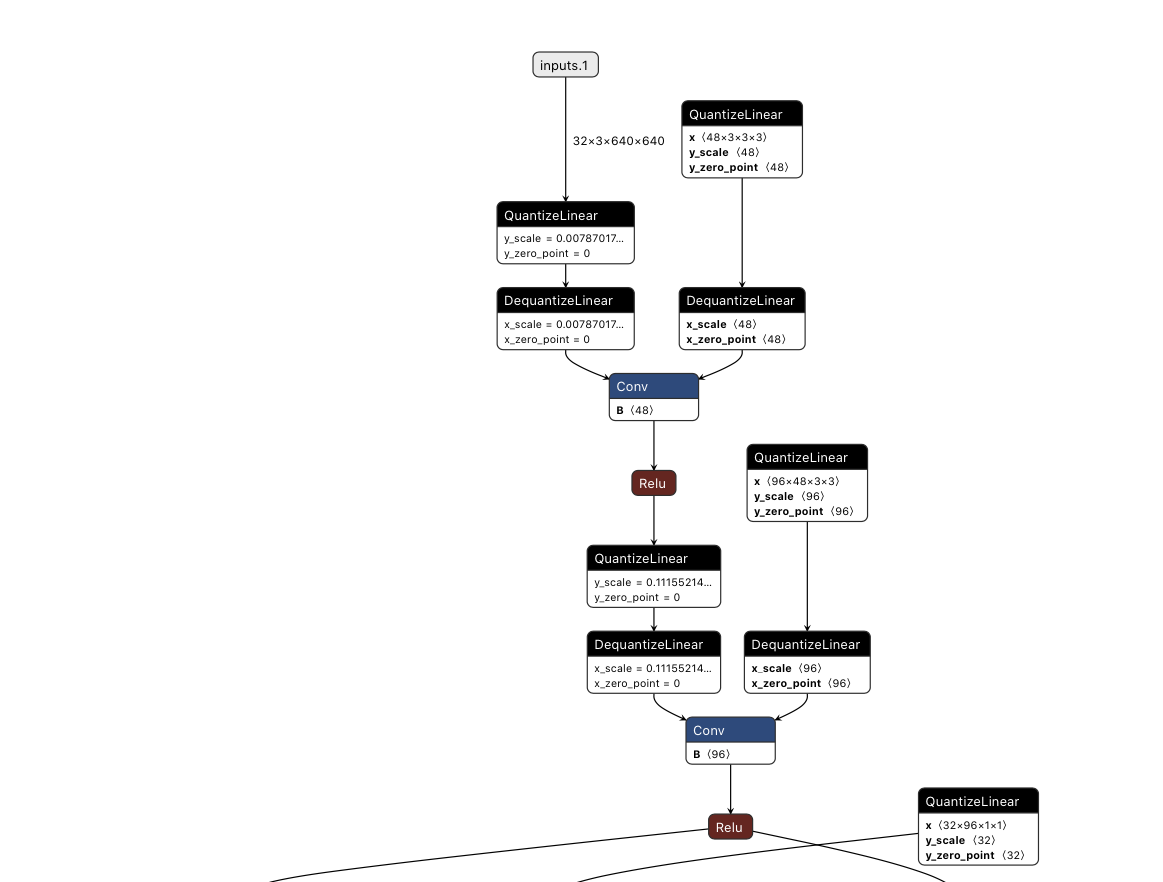

This is expected and a good way to verify that our model is ready to be converted to Int8 using Nvidia's [TesnorRT](https://docs.nvidia.com/deeplearning/tensorrt/quick-start-guide/index.html#deploy-engine):
 We can now use these ONNX files to deploy our newly trained YoloNAS models to production. When building the TRT engine it is important specify that we convert to Int8 (the fake quantized layers in our models will be adapted accordingly), this can be done by running:
`trtexec --fp16 --int8 --onnx=your_yolonas_qat_model.onnx`.

For more information on how to properly export and benchmark YoloNAS, click [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/BenchmarkingYoloNAS.md).